In [1]:
import os
import gc
import re
import random
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from datetime import datetime, date
from scipy import sparse
from tqdm import tqdm
from typing import List, Tuple

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score

In [2]:
def similarity_cosine(vec1, vec2):
    cosine_similarity_arr = []
    for v1,v2 in zip(vec1, vec2):
        cosine_similarity = np.dot(v1, v2)/(np.linalg.norm(v1)* np.linalg.norm(v2))
        cosine_similarity_arr.append(cosine_similarity)
    return np.array(cosine_similarity_arr)

def keep_words_with_underscore(input_string):
    # Define a regular expression pattern to match words with underscores
    pattern = r'\b\w*_[\w_]*\b'

    # Use re.findall to extract words that match the pattern
    matching_words = re.findall(pattern, input_string)

    # Join the matching words to form the final string
    result = ' '.join(matching_words)
    return result

def update_co_occurrences(word_year_list, word_co_occurrences):
    # Iterate through the words in the list
    word_list, year = word_year_list
    
    for word in word_list:
        # If the word is not already in the dictionary, add it with an empty list
        if word not in word_co_occurrences:
            word_co_occurrences[word] = {}
        
        # Add words from the list to the co-occurrence list for the current word
        for other_word in word_list:
            # if other_word != word and other_word not in word_co_occurrences[word]:
            #     word_co_occurrences[word].append(other_word)
            if other_word != word and other_word not in word_co_occurrences[word]:
                word_co_occurrences[word][other_word] = [year] 
            
            elif other_word != word and other_word in word_co_occurrences[word]:
                # word_co_occurrences[word][other_word][0] +=1
                word_co_occurrences[word][other_word].append(year)

In [3]:
concept_filtered_arr = np.memmap("saved_files/embedding_concept_arr.dat",shape=(10330,), dtype="<U55")
c_encoding_arr = np.memmap("saved_files/embedding_vector_arr.dat",shape=(10330, 31, 128), dtype=np.float64)

ngram_abstracts = np.load("saved_files/ngram_abstracts.npy", mmap_mode="r")
saved_year_arr = np.load("saved_files/year_arr.npy", mmap_mode="r")

print("Concepts which were tracked",concept_filtered_arr.shape)
print("Abstracts",ngram_abstracts.shape)
print("Year associated to abstract",saved_year_arr.shape)

phys_filtered_concept_dict = {k:1 for k in concept_filtered_arr}
ocurr_arr = []
for abstract, year in zip(ngram_abstracts, saved_year_arr):
    temp = keep_words_with_underscore(abstract)
    if temp.count(" ") > 0:
        temp = temp.split(" ") 
        temp = [s for s in temp if s in phys_filtered_concept_dict]
        ocurr_arr.append([list(filter(("_").__ne__, temp)),year])
                        
word_co_occurrences = {}

for word_list in tqdm(ocurr_arr):
    update_co_occurrences(word_list,word_co_occurrences)

Concepts which were tracked (10330,)
Abstracts (67503,)
Year associated to abstract (67503,)


100%|██████████| 64288/64288 [00:02<00:00, 24970.97it/s]


# knowledge Baseline

In [4]:
def replace_strings_with_indices(data, concept_to_index):
    # Create a new dictionary to store the converted data
    indexed_data = {}
    
    # Iterate through the outer dictionary
    for concept1, nested_dict in data.items():
        # Replace the concept1 string with its index
        # print(concept_to_index[concept1])
        index1 = concept_to_index[concept1][0]
        indexed_data[index1] = {}
        
        # Iterate through the inner dictionary
        for concept2, years in nested_dict.items():
            # Replace the concept2 string with its index
            
            index2 = concept_to_index[concept2][0]
            indexed_data[index1][index2] = years
    
    return indexed_data


concept_to_indices = {concept: np.where(concept_filtered_arr == concept)[0] for concept in np.unique(concept_filtered_arr)}
index_co_occurrences = replace_strings_with_indices(word_co_occurrences, concept_to_indices)

In [5]:
def create_graph_from_dict(data):
    # Create an empty graph
    G = nx.Graph()
    
    # Iterate through the outer dictionary
    for concept1, nested_dict in data.items():
        # Iterate through the inner dictionary
        for concept2, years in nested_dict.items():
            # If the edge already exists, add to the weight and append years
            if G.has_edge(concept1, concept2):
                G[concept1][concept2]['weight'] += len(years)
                G[concept1][concept2]['years'].extend(years)
            else:
                # Add a new edge with the weight and list of years
                G.add_edge(concept1, concept2, weight=len(years), years=years)
    
    # Remove duplicate years
    for u, v in G.edges():
        G[u][v]['years'] = list(set(G[u][v]['years']))
    
    return G

def convert_years_to_days_since_1990(years):
    base_date = datetime(1990, 1, 1)
    days_since_1990 = [(datetime(year, 1, 1) - base_date).days for year in years]
    return days_since_1990

def save_graph_edges(graph, filename):
    # Create a list of concepts and assign indices
    concepts = list(graph.nodes())
    concept_indices = {concept: idx for idx, concept in enumerate(concepts)}
    
    # Create the edge list in the specified format
    edge_list = []
    for u, v, data in graph.edges(data=True):
        if u>v:
            pass#print("no...", u,v,data)
        idx1 = concept_indices[u]
        idx2 = concept_indices[v]
        years = data['years']
        days = convert_years_to_days_since_1990(years)
        for day in days:
            edge_list.append([idx1, idx2, day])
    
    # Save the edge list as a .pkl file
    with open(filename, 'wb') as f:
        pickle.dump(edge_list, f)


graph = create_graph_from_dict(word_co_occurrences)
save_graph_edges(graph, 'saved_files/graph_edges.pkl')

# Print the edge list to verify
with open('saved_files/graph_edges.pkl', 'rb') as f:
    edge_list = pickle.load(f)
    print(edge_list[0])
    print(edge_list[-1])
    print(len(edge_list))


[0, 1, 11323]
[10311, 10314, 6940]
980905


# Prereq

In [6]:
NUM_OF_VERTICES=len(concept_filtered_arr)

def create_training_data(full_graph,year_start,years_delta,min_edges=1,edges_used=500000,vertex_degree_cutoff=10):
    """
    :param full_graph: Full graph, numpy array dim(n,3) [vertex 1, vertex 2, time stamp]
    :param year_start: year of graph
    :param years_delta: distance for prediction in years (prediction on graph of year_start+years_delta)
    :param min_edges: minimal number of edges that is considered
    :param edges_used: optional filter to create a random subset of edges for rapid prototyping (default: 500,000)
    :param vertex_degree_cutoff: optional filter, for vertices in training set having a minimal degree of at least vertex_degree_cutoff  (default: 10)
    :return:

    all_edge_list: graph of year_start, numpy array dim(n,2)
    unconnected_vertex_pairs: potential edges for year_start+years_delta
    unconnected_vertex_pairs_solution: numpy array with integers (0=unconnected, 1=connected), solution, length = len(unconnected_vertex_pairs)
    """
    print('\n')
    print('in create_training_data ')
    print('Creating the following data: ')
    
    print('    year_start: ', year_start)
    print('    years_delta: ', years_delta)
    print('    min_edges: ', min_edges)
    print('    edges_used: ', edges_used)
    print('    vertex_degree_cutoff: ', vertex_degree_cutoff)

    years=[year_start, year_start+years_delta]    
    day_origin = date(1990,1,1)

    all_G=[]
    all_edge_lists=[]
    all_sparse=[]
    all_degs=[]
    for yy in years:
        print('    Create Graph for ', yy)
        day_curr=date(yy,12,31)
        all_edges_curr=full_graph[full_graph[:,2]<(day_curr-day_origin).days]
        
        adj_mat_sparse_curr = sparse.csr_matrix((np.ones(len(all_edges_curr)), (all_edges_curr[:,0], all_edges_curr[:,1])), shape=(NUM_OF_VERTICES,NUM_OF_VERTICES))
        G_curr=nx.from_scipy_sparse_array(adj_mat_sparse_curr, parallel_edges=False, create_using=nx.MultiGraph)

        all_G.append(G_curr)
        all_sparse.append(adj_mat_sparse_curr)
        all_edge_lists.append(all_edges_curr)

        print('          num of edges: ', G_curr.number_of_edges())
        print('    Done: Create Graph for ', yy)
        

    all_degs=np.array(all_G[0].degree)[:,1]

    ## Create all edges to be predicted
    all_vertices=np.array(range(NUM_OF_VERTICES))
    
    vertex_large_degs=all_vertices[all_degs>=vertex_degree_cutoff] # use only vertices with degrees larger than 10.
    print("\n")
    print("all_vertices: ", len(all_vertices))
    print('len(vertex_large_degs): ',len(vertex_large_degs))

    unconnected_vertex_pairs=[]
    unconnected_vertex_pairs_solution=[]

    time_start=time.time()
    added_pairs = set()
    while len(unconnected_vertex_pairs)<edges_used:        
        i1,i2=random.sample(range(len(vertex_large_degs)), 2)
        
        v1=vertex_large_degs[i1]
        v2=vertex_large_degs[i2]

        if v1!=v2 and not all_G[0].has_edge(v1,v2):

            pair = (v1, v2) # currently keep the case (v2, v1)
            if pair not in added_pairs:

                if len(unconnected_vertex_pairs)%10**6==0:
                    time_end=time.time()
                    print('    edge progress (',time_end-time_start,'sec): ',len(unconnected_vertex_pairs)/10**6,'M/',edges_used/10**6,'M')
                    time_start=time.time()

                is_bigger=False
                if all_G[1].has_edge(v1,v2):
                    curr_weight=all_G[1].get_edge_data(v1,v2)[0]['weight']
                    if curr_weight>=min_edges:
                        is_bigger=True

                unconnected_vertex_pairs.append((v1,v2))
                unconnected_vertex_pairs_solution.append(is_bigger)
                added_pairs.add(pair)

    unconnected_vertex_pairs=np.array(unconnected_vertex_pairs)
    unconnected_vertex_pairs_solution=np.array(list(map(int, unconnected_vertex_pairs_solution)))

    all_edge_list=np.array(all_edge_lists[0]) ## the graph of year_start
    
    print('unconnected_vertex_pairs_solution: ',sum(unconnected_vertex_pairs_solution))
    
    return all_edge_list, unconnected_vertex_pairs, unconnected_vertex_pairs_solution


def create_training_data_biased(full_graph,year_start,years_delta,min_edges=1,edges_used=500000,vertex_degree_cutoff=10,data_source=''):
    """
    :param full_graph: Full graph, numpy array dim(n,3) [vertex 1, vertex 2, time stamp]
    :param year_start: year of graph
    :param years_delta: distance for prediction in years (prediction on graph of year_start+years_delta)
    :param min_edges: minimal number of edges that is considered
    :param edges_used: optional filter to create a random subset of edges for rapid prototyping (default: 500,000)
    :param vertex_degree_cutoff: optional filter, for vertices in training set having a minimal degree of at least vertex_degree_cutoff  (default: 10)
    :return:

    all_edge_list: graph of year_start, numpy array dim(n,2)
    unconnected_vertex_pairs: potential edges for year_start+years_delta
    unconnected_vertex_pairs_solution: numpy array with integers (0=unconnected, 1=connected), solution, length = len(unconnected_vertex_pairs)
    """
    with open("logs_"+data_source+".txt", "a") as myfile:
        myfile.write('\nin create_training_data_biased')      
    print('\n')
    print('in create_training_data_biased ')
    print('Creating the following data: ')
    
    print('    year_start: ', year_start)
    print('    years_delta: ', years_delta)
    print('    min_edges: ', min_edges)
    print('    edges_used: ', edges_used)
    print('    vertex_degree_cutoff: ', vertex_degree_cutoff)

    years=[year_start,year_start+years_delta]    
    day_origin = date(1990, 1, 1)

    all_G=[]
    all_edge_lists=[]
    all_sparse=[]
    all_degs=[]
    for yy in years:
        with open("logs_"+data_source+".txt", "a") as myfile:
            myfile.write('\n    Create Graph for '+str(yy))    
        print('    Create Graph for ', yy)
        day_curr=date(yy,12,31)
        all_edges_curr=full_graph[full_graph[:,2]<(day_curr-day_origin).days]
        adj_mat_sparse_curr = sparse.csr_matrix((np.ones(len(all_edges_curr)), (all_edges_curr[:,0], all_edges_curr[:,1])), shape=(NUM_OF_VERTICES,NUM_OF_VERTICES))
        G_curr=nx.from_scipy_sparse_array(adj_mat_sparse_curr, parallel_edges=False, create_using=nx.MultiGraph)

        all_G.append(G_curr)
        all_sparse.append(adj_mat_sparse_curr)
        all_edge_lists.append(all_edges_curr)

        print('          num of edges: ', G_curr.number_of_edges())
        print('    Done: Create Graph for ', yy)
        

    all_degs=np.array(all_G[0].degree)[:,1]

    ## Create all edges to be predicted
    all_vertices=np.array(range(NUM_OF_VERTICES))
    vertex_large_degs=all_vertices[all_degs>=vertex_degree_cutoff] # use only vertices with degrees larger than 10.
    print(f"\nlen(all_vertices): {len(all_vertices)}")
    print(f"len(vertex_large_degs): {len(vertex_large_degs)}\n")
    with open("logs_"+data_source+".txt", "a") as myfile:
        myfile.write('\nlen(vertex_large_degs): '+str(len(vertex_large_degs)))

    unconnected_vertex_pairs=[]
    unconnected_vertex_pairs_solution=[]

    time_start=time.time()
    cT=0
    cF=0
    old_c=0
    added_pairs = set()
    ## equal number of false and true samples
    while (cT<(edges_used/2)) or (cF<(edges_used/2)):        
        i1,i2=random.sample(range(len(vertex_large_degs)), 2)
        
        v1=vertex_large_degs[i1]
        v2=vertex_large_degs[i2]

        if v1!=v2 and not all_G[0].has_edge(v1,v2): ## unconnected in 2018
            
            pair = (v1, v2) # currently keep the case (v2, v1)
            if pair not in added_pairs:
            
                if len(unconnected_vertex_pairs)%10**4==0 and len(unconnected_vertex_pairs)!=old_c:
                    time_end=time.time()
                    
                    print(f"    edge progress ({time_end-time_start}sec): {len(unconnected_vertex_pairs)/10**6}M/{edges_used/10**6}M; True: {cT}; False: {cF}")
                    
                    with open("logs_"+data_source+".txt", "a") as myfile:
                        myfile.write('\n    edge progress ('+str(time_end-time_start)+'sec): '+str(len(unconnected_vertex_pairs)/10**6)+'M/'+str(edges_used/10**6)+'M '+str(cT)+' '+str(cF))
                    old_c=len(unconnected_vertex_pairs)
                    time_start=time.time()
                

                is_bigger=False
                if all_G[1].has_edge(v1,v2): ## connected in 2021
                    curr_weight=all_G[1].get_edge_data(v1,v2)[0]['weight']
                    if curr_weight>=min_edges:
                        is_bigger=True

                if is_bigger==False and cF<edges_used/2:
                    unconnected_vertex_pairs.append((v1,v2))
                    unconnected_vertex_pairs_solution.append(is_bigger)
                    cF+=1
                if is_bigger==True and cT<edges_used/2:
                    unconnected_vertex_pairs.append((v1,v2))
                    unconnected_vertex_pairs_solution.append(is_bigger)
                    cT+=1
                    #print("yes...")
                added_pairs.add(pair)
            
            
    print("(edges_used/2), cT, cF: ", (edges_used/2), cT, cF)
    with open("logs_"+data_source+".txt", "a") as myfile:
        myfile.write('\nnearly done here')

    unconnected_vertex_pairs=np.array(unconnected_vertex_pairs)
    unconnected_vertex_pairs_solution=np.array(list(map(int, unconnected_vertex_pairs_solution)))

    all_edge_list=np.array(all_edge_lists[0]) # graph of year_start
    
    print('unconnected_vertex_pairs_solution: ',sum(unconnected_vertex_pairs_solution))
    
    return all_edge_list, unconnected_vertex_pairs, unconnected_vertex_pairs_solution



def calculate_ROC(data_vertex_pairs,data_solution, train_info):
    data_solution=np.array(data_solution)
    data_vertex_pairs_sorted=data_solution[data_vertex_pairs]
    
    xpos=[0]
    ypos=[0]
    ROC_vals=[]
    for ii in range(len(data_vertex_pairs_sorted)):
        if data_vertex_pairs_sorted[ii]==1:
            xpos.append(xpos[-1])
            ypos.append(ypos[-1]+1)
        if data_vertex_pairs_sorted[ii]==0:
            xpos.append(xpos[-1]+1)
            ypos.append(ypos[-1])      
            ROC_vals.append(ypos[-1])
    
        # # # # # # # # # # # # # # # 
        # 
        # We normalize the ROC curve such that it starts at (0,0) and ends at (1,1).
        # Then our final metric of interest is the Area under that curve.
        # AUC is between [0,1].
        # AUC = 0.5 is acchieved by random predictions
        # AUC = 1.0 stands for perfect prediction.
    
    ROC_vals=np.array(ROC_vals)/max(ypos)
    ypos=np.array(ypos)/max(ypos)
    xpos=np.array(xpos)/max(xpos)
    AUC=sum(ROC_vals)/len(ROC_vals)

    plt.title(f"AUC: {AUC}; {train_info}")
    plt.plot(xpos, ypos)
    plt.show()
    plt.close()

    return AUC

# Neural Network Train model

In [10]:
class ff_network(nn.Module):

    def __init__(self):
        """
        Fully Connected layers
        """
        super(ff_network, self).__init__()

        self.semnet = nn.Sequential( # very small network for tests
            nn.Linear(15, 100), # 15 properties
            nn.ReLU(),
            nn.Linear(100, 100), 
            nn.ReLU(),       
            nn.Linear(100, 10),
            nn.ReLU(),             
            nn.Linear(10, 1)
        )


    def forward(self, x):
        """
        Pass throught network
        """
        res = self.semnet(x)

        return res


def train_model(model_semnet, data_train0, data_train1, data_test0, data_test1, lr_enc, batch_size, data_source, year_start, year_delta):
    """
    Training the neural network
    """            
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    size_of_loss_check=2000
    
    optimizer_predictor = torch.optim.Adam(model_semnet.parameters(), lr=lr_enc)
    
    data_train0=torch.tensor(data_train0, dtype=torch.float).to(device)
    data_test0=torch.tensor(data_test0, dtype=torch.float).to(device)
    
    data_train1=torch.tensor(data_train1, dtype=torch.float).to(device)
    data_test1=torch.tensor(data_test1, dtype=torch.float).to(device)

    test_loss_total=[]
    moving_avg=[]
    criterion = torch.nn.MSELoss()
    
    # There are much more vertex pairs that wont be connected (0) rather than ones
    # that will be connected (1). However, we observed that training with an equally weighted
    # training set (same number of examples for (0) and (1)) results in more stable training.
    # (Imaging we have 1.000.000 nonconnected and 10.000 connected)
    #
    # For that reason, we dont have true 'episodes' (where each example from the training set
    # has been used in the training). Rather, in each of our iteration, we sample batch_size
    # random training examples from data_train0 and from data_train1.
    
    for iteration in range(50000): # should be much larger, with good early stopping criteria
        model_semnet.train()
        data_sets=[data_train0,data_train1]
        total_loss=0
        for idx_dataset in range(len(data_sets)):
            idx = torch.randint(0, len(data_sets[idx_dataset]), (batch_size,))
            data_train_samples = data_sets[idx_dataset][idx]
            calc_properties = model_semnet(data_train_samples)
            curr_pred=torch.tensor([idx_dataset] * batch_size, dtype=torch.float).to(device)
            real_loss = criterion(calc_properties, curr_pred)
            total_loss += torch.clamp(real_loss, min = 0., max = 50000.).double()

        optimizer_predictor.zero_grad()
        total_loss.backward()
        optimizer_predictor.step()

        # Evaluating the current quality.
        with torch.no_grad():
            model_semnet.eval()
            # calculate train set
            eval_datasets=[data_train0,data_train1,data_test0,data_test1]
            all_real_loss=[]
            for idx_dataset in range(len(eval_datasets)):
                eval_datasets[idx_dataset]
                calc_properties = model_semnet(eval_datasets[idx_dataset][0:size_of_loss_check])        
                curr_pred=torch.tensor([idx_dataset%2] * len(eval_datasets[idx_dataset][0:size_of_loss_check]), dtype=torch.float).to(device)
                real_loss = criterion(calc_properties, curr_pred)
                all_real_loss.append(real_loss.detach().cpu().numpy())
             
            test_loss_total.append(np.mean(all_real_loss[2])+np.mean(all_real_loss[3]))

            if iteration%50==0:
                info_str='iteration: '+str(iteration)+' - train loss: '+str(np.mean(all_real_loss[0])+np.mean(all_real_loss[1]))+'; test loss: '+str(np.mean(all_real_loss[2])+np.mean(all_real_loss[3]))
                print('    train_model: ',info_str)
                with open("logs_"+data_source+".txt", "a") as myfile:
                    myfile.write('\n    train_model: '+info_str)

            if test_loss_total[-1]==min(test_loss_total): ## store the best model
                model_semnet.eval()
                torch.save(model_semnet, f'neural_net_full_{str(year_start)}_{str(year_delta)}')
                torch.save(model_semnet.state_dict(), f'neural_net_state_{str(year_start)}_{str(year_delta)}.pt')  
                model_semnet.train()
                with open(data_source+"_logs.txt", "a") as myfile:
                    myfile.write('\n    stored model ')

            if len(test_loss_total)>200: # early stopping
                test_loss_moving_avg=sum(test_loss_total[-100:])
                moving_avg.append(test_loss_moving_avg)
                if len(moving_avg)>10:
                    if moving_avg[-1]>moving_avg[-5] and moving_avg[-1]>moving_avg[-25]:
                        print('    Early stopping kicked in')
                        break

    plt.plot(test_loss_total)
    plt.title(f"test loss: year_start: {str(year_start)}, year_delta: {str(year_delta)}")
    plt.show()
    
    plt.plot(test_loss_total[500:])
    plt.title(f"test loss, last 500: year_start: {str(year_start)}, year_delta: {str(year_delta)}")
    plt.show()    
    
    plt.plot(moving_avg)
    plt.title(f'moving avg loss: year_start: {str(year_start)}, year_delta: {str(year_delta)}')
    plt.show()
    plt.close()

    return True
    

def compute_all_properties(all_sparse, AA02,AA12,AA22,all_degs0,all_degs1,all_degs2,all_degs02,all_degs12,all_degs22,v1,v2):
    """
    Computes hand-crafted properties for one vertex in vlist
    """
    all_properties=[]

    all_properties.append(all_degs0[v1]) # 0
    all_properties.append(all_degs0[v2]) # 1
    all_properties.append(all_degs1[v1]) # 2
    all_properties.append(all_degs1[v2]) # 3
    all_properties.append(all_degs2[v1]) # 4
    all_properties.append(all_degs2[v2]) # 5
    all_properties.append(all_degs02[v1]) # 6
    all_properties.append(all_degs02[v2]) # 7
    all_properties.append(all_degs12[v1]) # 8
    all_properties.append(all_degs12[v2]) # 9
    all_properties.append(all_degs22[v1]) # 10
    all_properties.append(all_degs22[v2]) # 11

    all_properties.append(AA02[v1,v2]) # 12
    all_properties.append(AA12[v1,v2]) # 13
    all_properties.append(AA22[v1,v2]) # 14    

    return all_properties



def compute_all_properties_of_list(all_sparse,vlist,data_source):
    """
    Computes hand-crafted properties for all vertices in vlist
    """
    time_start=time.time()
    AA02=all_sparse[0]**2
    AA02=AA02/AA02.max()
    AA12=all_sparse[1]**2
    AA12=AA12/AA12.max()
    AA22=all_sparse[2]**2
    AA22=AA22/AA22.max()
    
    all_degs0=np.array(all_sparse[0].sum(0))[0]
    if np.max(all_degs0)>0:
        all_degs0=all_degs0/np.max(all_degs0)
        
    all_degs1=np.array(all_sparse[1].sum(0))[0]
    if np.max(all_degs1)>0:
        all_degs1=all_degs1/np.max(all_degs1)
    
    all_degs2=np.array(all_sparse[2].sum(0))[0]
    if np.max(all_degs2)>0:
        all_degs2=all_degs2/np.max(all_degs2)

    all_degs02=np.array(AA02[0].sum(0))[0]
    if np.max(all_degs02)>0:
        all_degs02=all_degs02/np.max(all_degs02)
        
    all_degs12=np.array(AA12[1].sum(0))[0]
    if np.max(all_degs12)>0:
        all_degs12=all_degs12/np.max(all_degs12)
        
    all_degs22=np.array(AA22[2].sum(0))[0]
    if np.max(all_degs22)>0:
        all_degs22=all_degs22/np.max(all_degs22)
    
    all_properties=[]
    print('    Computed all matrix squares, ready to ruuuumbleeee...')
    for ii in range(len(vlist)):
        vals=compute_all_properties(all_sparse,
                                    AA02,
                                    AA12,
                                    AA22,
                                    all_degs0,
                                    all_degs1,
                                    all_degs2,
                                    all_degs02,
                                    all_degs12,
                                    all_degs22,
                                    vlist[ii][0],
                                    vlist[ii][1])

        all_properties.append(vals)
        if ii%10**4==0:
            print('    compute_all_properties_of_list progress: (',time.time()-time_start,'sec) ',ii/10**6,'M/',len(vlist)/10**6,'M')

            with open("logs_"+data_source+".txt", "a") as myfile:
                myfile.write('\n    compute_all_properties_of_list progress: ('+str(time.time()-time_start)+'sec) '+str(ii/10**6)+'M/'+str(len(vlist)/10**6)+'M')

            time_start=time.time()

    return all_properties


def flatten(t):
    return [item for sublist in t for item in sublist]

# year_start:2018 years_delta=3
def link_prediction_semnet(full_dynamic_graph_sparse,unconnected_vertex_pairs,year_start, year_delta,vertex_degree_cutoff,min_edges,hyper_parameters,data_source):
    """
    Gets an evolving semantic network and a list of unconnected vertices,
    and returns an index list of which vertex pairs are most likely to be
    connected at a later time t2 (from likely to unlikely)
    
    :param full_dynamic_graph_sparse: Full graph, numpy array dim(n,3)
            [vertex v1, vertex v2, time stamp t1] representing edges, up
            to t<=t1. The edge is formed between vertex v1 and v2 at time t
            (measured in days after 1.1.1990)
    :param unconnected_vertex_pairs, numpy array of vertex
            pairs [v1,v2] with no edge at t1 and deg(v1/2)>10. Question is
            whether these vertex pairs will have an edge at t2.
    :param year_start - Integer, year for t1. Edges with
            t1=(date(year_start,12,31)-date(1990,1,1)).days are included
            in full_dynamic_graph_sparse
    :param years_delta, Integer, number if years to predict,
            t2=(date(year_start+years_delta,12,31)-date(1990,1,1)).days
    :param vertex_degree_cutoff, Integer, number of minimal vertex degree for
            prediction 
    :param min_edges, Integer, Predict edges which grew from zero to min_edges 
        
    Output - sorted_predictions_eval, numpy array with
            len(..)=len(unconnected_vertex_pairs).
            Sorted of which pairs in unconnected_vertex_pairs
            are most likely to be connected at t2. Used for computing the
            AUC metric.

    
    This is a simple baseline model, with the following workflow:
    1) Learns to predict using training data from 2011 -> 2014.
          1.1) For that, it uses 
                     train_dynamic_graph_sparse,
                     train_edges_for_checking,
                     train_edges_solution=
                     create_training_data(
                                          full_graph,
                                          year_start=2014,
                                          years_delta=3,
                                          edges_used,
                                          vertex_degree_cutoff
                                         )
               train_dynamic_graph_sparse - Semantic network until 2014
               (numpy array with triples for each edge [v1,v2,t])
               train_edges_for_checking - list of unconnected vertices in
               2011 and computes whether they are connected by 2014.
                   
               edges_used, unconnected edges that are used in training.
               
               train_edges_solution is a numpy array stating whether an
               element in edges_used has beendata_source connected in t2
               
          1.2) It computes a list of 15 properties of each edge in the
               train_edges_for_checking. The properties contain the
               local degrees of the vertices, numbers of shared neighbors
               and paths of length 3, in the year 2011, 2010 and 2009.
          1.3) Those 15 properties per vertex pair are input into a neural
               network, which predicts whether the vertex pairs will be
               connected or not (using train_edges_solution)
          1.4) Computes the AUC for training and test data using
               calculate_ROC.
    
    2) Makes predictions for 2014 -> 2017 data.
          2.1) Computes the 15 properties for the 2014 data.
          2.2) Uses the trained network to predict whether edges are
               created by 2017.
    
    3) Creates a sorted index list, from highest predicted vertex pair to
        least predicted one (sorted_predictions)
    
    4) Returns sorted_predictions
    """

    edges_used, percent_positive_examples, batch_size, lr_enc, rnd_seed=hyper_parameters

    random.seed(rnd_seed)
    torch.manual_seed(rnd_seed)
    np.random.seed(rnd_seed)
    
    print('1) Learns to predict using training data from '+str(year_start-year_delta)+' -> '+str(year_start))
    
    print('1.1) Create training data for '+str(year_start-year_delta))

    with open("logs_"+data_source+".txt", "a") as myfile:
        myfile.write('1.1) Create training data for '+str(year_start-year_delta)+'\n') 
    
    #create_training_data_biased
    #train_dynamic_graph_sparse,train_edges_for_checking,train_edges_solution = create_training_data(full_dynamic_graph_sparse, year_start-years_delta, years_delta, min_edges=min_edges, edges_used=edges_used, vertex_degree_cutoff=vertex_degree_cutoff)
    train_dynamic_graph_sparse,train_edges_for_checking,train_edges_solution = create_training_data_biased(full_dynamic_graph_sparse, year_start-year_delta, year_delta, min_edges=min_edges, edges_used=edges_used, vertex_degree_cutoff=vertex_degree_cutoff, data_source=data_source)

    day_origin = date(1990,1,1)
    years=[year_start-year_delta,year_start-year_delta-1,year_start-year_delta-2]
    print('    years: ', years)
    train_sparse=[]
    for yy in years:
        print('    Create Graph for ', yy)
        day_curr=date(yy,12,31)
        train_edges_curr=train_dynamic_graph_sparse[train_dynamic_graph_sparse[:,2]<(day_curr-day_origin).days]
        adj_mat_sparse_curr = sparse.csr_matrix((np.ones(len(train_edges_curr)), (train_edges_curr[:,0], train_edges_curr[:,1])), shape=(NUM_OF_VERTICES,NUM_OF_VERTICES))
    
        train_sparse.append(adj_mat_sparse_curr)
    
    
    print('    Shuffle training data...')
    with open("logs_"+data_source+".txt", "a") as myfile:
        myfile.write('\n    Shuffle training data...\n')     
    train_valid_test_size=[0.9, 0.1, 0.0]
    x = [i for i in range(len(train_edges_for_checking))]  # random shuffle input

    random.shuffle(x)
    train_edges_for_checking = train_edges_for_checking[x]
    train_edges_solution = train_edges_solution[x]

    print('    Split dataset...')
    idx_traintest=int(len(train_edges_for_checking)*train_valid_test_size[0])

    data_edges_train=train_edges_for_checking[0:idx_traintest]
    solution_train=train_edges_solution[0:idx_traintest]  

    data_edges_test=train_edges_for_checking[idx_traintest:]
    solution_test=train_edges_solution[idx_traintest:]

    gc.collect()

    print('1.2) Compute 15 network properties for training data y=',year_start-year_delta)

    print('    Prepare data for equally distributed training...')
    print('    This is an important design choice for training the NN.')
    print('    Note that the evaluation set (also for the competition) is NOT equally distributed!')
    with open("logs_"+data_source+".txt", "a") as myfile:
        myfile.write('\n1.2) Compute 15 network properties for training data y='+str(year_start-year_delta))   

    # Rather than using all connected and unconnected vertex pairs for training
    # (i.e. needing to compute their properties), we reject about 99% of all unconnected
    # examples, to have more examples of connected cases in the training. This significantly
    # speeds up the computation, at the price of precision.
    data_edges_train_smaller=[]
    solution_train_smaller=[]
    for ii in range(len(data_edges_train)):
        if (solution_train[ii]==0 and random.random()<percent_positive_examples) or solution_train[ii]==1:
            data_edges_train_smaller.append(data_edges_train[ii])
            solution_train_smaller.append(solution_train[ii])
    
    with open("logs_"+data_source+".txt", "a") as myfile:
        myfile.write('\nComputing properties for Training data')   
    print('Computing properties for Training data')
    data_train=compute_all_properties_of_list(train_sparse,data_edges_train_smaller,data_source)
    gc.collect()

    data_train0=[]
    data_train1=[]
    for ii in range(len(data_edges_train_smaller)):
        if solution_train_smaller[ii]==1:
            data_train1.append(data_train[ii])
        else:
            data_train0.append(data_train[ii])

    gc.collect()
    with open("logs_"+data_source+".txt", "a") as myfile:
        myfile.write('\nComputing properties for Test data')   
    print('Computing properties for Test data')
    data_test=compute_all_properties_of_list(train_sparse,data_edges_test,data_source)
    data_test0=[]
    data_test1=[]
    for ii in range(len(data_edges_test)):
        if solution_test[ii]==1:
            data_test1.append(data_test[ii])
        else:
            data_test0.append(data_test[ii])

    with open("logs_"+data_source+".txt", "a") as myfile:
        myfile.write('\n1.3) Train Neural Network')   
    print('1.3) Train Neural Network')      
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model_semnet = ff_network().to(device)
    gc.collect()
    model_semnet.train()
    train_model(model_semnet, data_train0, data_train1, data_test0, data_test1, lr_enc, batch_size, data_source, year_start-year_delta, year_delta)    
    
    with open("logs_"+data_source+".txt", "a") as myfile:
        myfile.write('\n1.4) Computes the AUC for training and test data using calculate_ROC.')       
    print('1.4) Computes the AUC for training and test data using calculate_ROC.')
    model_semnet.eval()
    
    data_train=torch.tensor(data_train, dtype=torch.float).to(device)
    all_predictions_train=flatten(model_semnet(data_train).detach().cpu().numpy())
    sorted_predictions_train=np.flip(np.argsort(all_predictions_train,axis=0)) 
    train_info=f"year: {year_start-year_delta}, delta: {year_delta}"    
    AUC_train=calculate_ROC(sorted_predictions_train, solution_train_smaller, train_info)
    print('    AUC_train: ', AUC_train)
    gc.collect()
    data_test=torch.tensor(data_test, dtype=torch.float).to(device)
    all_predictions_test=flatten(model_semnet(data_test).detach().cpu().numpy())
    sorted_predictions_test=np.flip(np.argsort(all_predictions_test,axis=0))  
    train_info=f"year: {year_start-year_delta}, delta: {year_delta}"  
    AUC_test=calculate_ROC(sorted_predictions_test, solution_test, train_info)
    print('    AUC_test: ', AUC_test)

    if len(unconnected_vertex_pairs)>0:
        # Create properties for evaluation
        print('2) Makes predictions for '+str(year_start)+' -> '+str(year_start+year_delta)+' data.')
        years=[year_start,year_start-1,year_start-2]

        with open("logs_"+data_source+".txt", "a") as myfile:
            myfile.write('\n2.1) Computes the 15 properties for the '+str(year_start)+' data.')    
        print('2.1) Computes the 15 properties for the '+str(year_start)+' data.')
        eval_sparse=[]
        for yy in years:
            print('    Create Graph for ', yy)
            day_curr=date(yy,12,31)
            eval_edges_curr=full_dynamic_graph_sparse[full_dynamic_graph_sparse[:,2]<(day_curr-day_origin).days]
            adj_mat_sparse_curr = sparse.csr_matrix(
                                                    (np.ones(len(eval_edges_curr)), (eval_edges_curr[:,0], eval_edges_curr[:,1])),
                                                    shape=(NUM_OF_VERTICES,NUM_OF_VERTICES)
                                                )

            eval_sparse.append(adj_mat_sparse_curr)

        with open("logs_"+data_source+".txt", "a") as myfile:
            myfile.write('\n    compute all properties for evaluation')    
        print('    compute all properties for evaluation')
        eval_examples=compute_all_properties_of_list(eval_sparse,unconnected_vertex_pairs,data_source)
        eval_examples=np.array(eval_examples)
        
        with open("logs_"+data_source+".txt", "a") as myfile:
            myfile.write('\n2.2) Uses the trained network to predict whether edges are created by '+str(year_start+year_delta)+'.')        
        print('2.2) Uses the trained network to predict whether edges are created by '+str(year_start+year_delta)+'.')
        eval_examples=torch.tensor(eval_examples, dtype=torch.float).to(device)
        all_predictions_eval=flatten(model_semnet(eval_examples).detach().cpu().numpy())

        with open("logs_"+data_source+".txt", "a") as myfile:
            myfile.write('\n3) Creates a sorted index list, from highest predicted vertex pair to least predicted one (sorted_predictions)')    
        print('3) Creates a sorted index list, from highest predicted vertex pair to least predicted one (sorted_predictions)')
        sorted_predictions_eval=np.flip(np.argsort(all_predictions_eval,axis=0))   
        
        print('4) Returns sorted_predictions')
        gc.collect()
        return sorted_predictions_eval
    else:
        return []  ## no predictions to be made

# Generate Data

In [8]:
if not ('saved_files/full_dynamic_graph_sparse' in locals() or 'saved_files/full_dynamic_graph_sparse' in globals()):
    print('Read full graph')
    with open('saved_files/graph_edges.pkl', "rb" ) as pkl_file:
        full_dynamic_graph_sparse_read = pickle.load(pkl_file)
        
    full_dynamic_graph_sparse=[]
    cc=0
    for edge in full_dynamic_graph_sparse_read:
        if edge[0]!=edge[1]:
            full_dynamic_graph_sparse.append(edge)
        else:
            print(cc,': ',edge) 
            
    full_dynamic_graph_sparse_read=[]        

else:
    print('already stored all_edges')

print('done')

## prepare 
all_vertex_degree_cutoff=[1] # vertex degree is 1, means that the vertex is connected to at least one other vertex
all_delta=[5] # time gap, unconnected pairs in y, the corresponding connection in y+delta
all_min_edges=[1] # every two vertices should have at least 1 edge between them
load = False 
if not load:

    for curr_vertex_degree_cutoff in all_vertex_degree_cutoff:
        for current_delta in all_delta:
            for current_min_edges in all_min_edges:
                print('---')
                #year_start=2021-current_delta
                 
                ## if you want just do train 2020 for 2023, need to set year_start=2023 (which stand for 2023.12.31), no evaluation
                ## this will store edge pairs for year_start, and unconnected pairs for year_start+current_delta
                year_start=2023-current_delta 

                train_dynamic_graph_sparse,train_edges_for_checking,train_edges_solution = create_training_data(
                    full_graph=np.array(full_dynamic_graph_sparse),
                    year_start=year_start,
                    years_delta=current_delta,
                    min_edges=current_min_edges,
                    edges_used=1e7,
                    vertex_degree_cutoff=curr_vertex_degree_cutoff
                )
                print('current_delta: ',current_delta, '; curr_vertex_degree_cutoff: ', curr_vertex_degree_cutoff, '; current_min_edges: ', current_min_edges)
                print('len(train_dynamic_graph_sparse): ',len(train_dynamic_graph_sparse))
                
                curr_file_name=f"SemanticGraph_year_{str(year_start)}_delta_{str(current_delta)}_cutoff_{str(curr_vertex_degree_cutoff)}_minedge_{str(current_min_edges)}.pkl"
        
                with open(curr_file_name, "wb") as output_file:
                    pickle.dump([
                        train_dynamic_graph_sparse,
                        train_edges_for_checking,
                        train_edges_solution,                
                        year_start,
                        current_delta,
                        curr_vertex_degree_cutoff,
                        current_min_edges
                        ], output_file)    
                    
                gc.collect()

Read full graph
done
---


in create_training_data 
Creating the following data: 
    year_start:  2018
    years_delta:  5
    min_edges:  1
    edges_used:  10000000.0
    vertex_degree_cutoff:  1
    Create Graph for  2018
          num of edges:  431810
    Done: Create Graph for  2018
    Create Graph for  2023
          num of edges:  647103
    Done: Create Graph for  2023


all_vertices:  10330
len(vertex_large_degs):  10132
    edge progress ( 0.00010704994201660156 sec):  0.0 M/ 10.0 M
    edge progress ( 4.555298805236816 sec):  1.0 M/ 10.0 M
    edge progress ( 4.486949920654297 sec):  2.0 M/ 10.0 M
    edge progress ( 4.762290000915527 sec):  3.0 M/ 10.0 M
    edge progress ( 4.5577311515808105 sec):  4.0 M/ 10.0 M
    edge progress ( 4.623842239379883 sec):  5.0 M/ 10.0 M
    edge progress ( 4.852564811706543 sec):  6.0 M/ 10.0 M
    edge progress ( 5.185760021209717 sec):  7.0 M/ 10.0 M
    edge progress ( 5.179970741271973 sec):  8.0 M/ 10.0 M
    edge progress ( 4.9916

# Train and Evaluate

unconnected_vertex_pairs: 10000000
unconnected_vertex_pairs_solution: 10000000
Number of 1s in train_edges_solution: 41154
year_start: 2018; years_delta: 5; vertex_degree_cutoff: 1; min_edges: 1
1) Learns to predict using training data from 2013 -> 2018
1.1) Create training data for 2013


in create_training_data_biased 
Creating the following data: 
    year_start:  2013
    years_delta:  5
    min_edges:  1
    edges_used:  100000.0
    vertex_degree_cutoff:  1
    Create Graph for  2013
          num of edges:  276446
    Done: Create Graph for  2013
    Create Graph for  2018
          num of edges:  431810
    Done: Create Graph for  2018

len(all_vertices): 10330
len(vertex_large_degs): 9418

    edge progress (0.04551815986633301sec): 0.01M/0.1M; True: 37; False: 9963
    edge progress (0.04330325126647949sec): 0.02M/0.1M; True: 75; False: 19925
    edge progress (0.041580915451049805sec): 0.03M/0.1M; True: 109; False: 29891
    edge progress (0.04333806037902832sec): 0.04M/0.1M

/opt/anaconda3/envs/asl_semnet/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([400])) that is different to the input size (torch.Size([400, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/anaconda3/envs/asl_semnet/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2000])) that is different to the input size (torch.Size([2000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


    train_model:  iteration: 0 - train loss: 0.8044756; test loss: 0.804309
    train_model:  iteration: 50 - train loss: 0.77258664; test loss: 0.77251816
    train_model:  iteration: 100 - train loss: 0.74289453; test loss: 0.74289376
    train_model:  iteration: 150 - train loss: 0.7125489; test loss: 0.7126072
    train_model:  iteration: 200 - train loss: 0.6786515; test loss: 0.67877734
    train_model:  iteration: 250 - train loss: 0.6436217; test loss: 0.64379334
    train_model:  iteration: 300 - train loss: 0.6077385; test loss: 0.60797745
    train_model:  iteration: 350 - train loss: 0.5723164; test loss: 0.572601
    train_model:  iteration: 400 - train loss: 0.5388455; test loss: 0.53913707
    train_model:  iteration: 450 - train loss: 0.50947106; test loss: 0.5097649
    train_model:  iteration: 500 - train loss: 0.4848761; test loss: 0.48516595
    train_model:  iteration: 550 - train loss: 0.46670878; test loss: 0.46695012
    train_model:  iteration: 600 - train loss

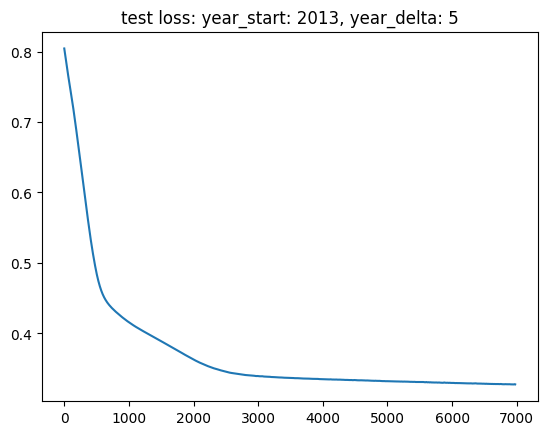

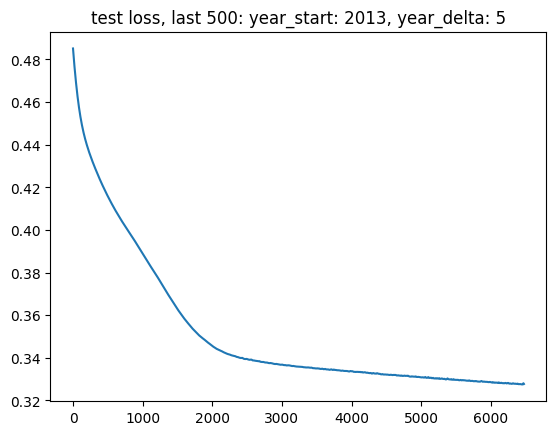

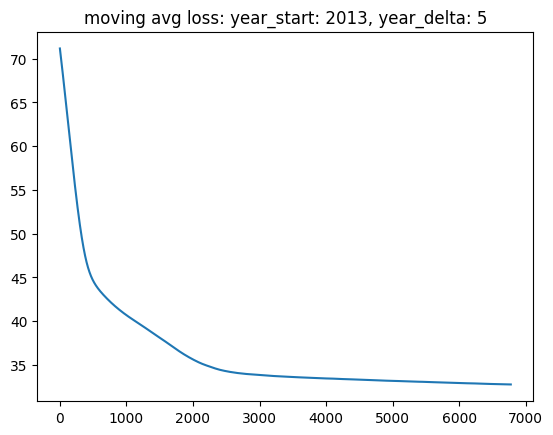

1.4) Computes the AUC for training and test data using calculate_ROC.


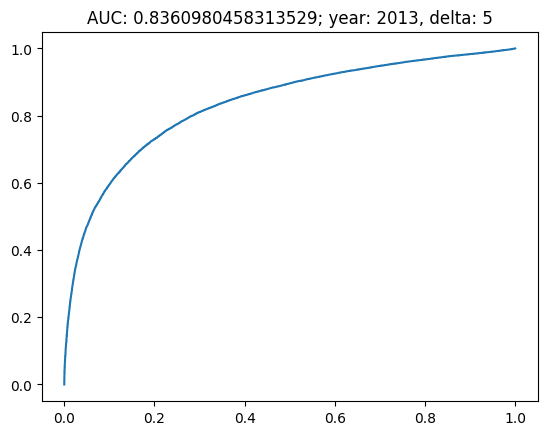

    AUC_train:  0.8360980458313529


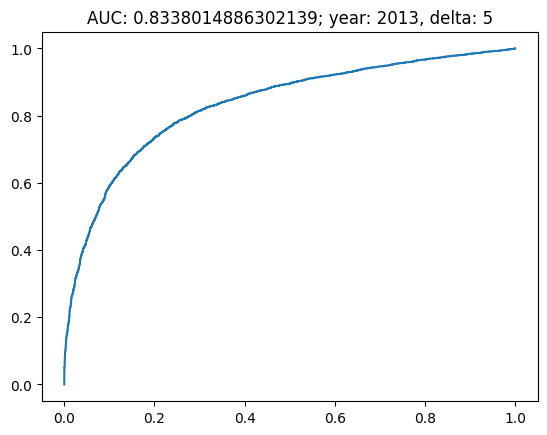

    AUC_test:  0.8338014886302139
2) Makes predictions for 2018 -> 2023 data.
2.1) Computes the 15 properties for the 2018 data.
    Create Graph for  2018
    Create Graph for  2017
    Create Graph for  2016
    compute all properties for evaluation
    Computed all matrix squares, ready to ruuuumbleeee...
    compute_all_properties_of_list progress: ( 2.2372381687164307 sec)  0.0 M/ 10.0 M
    compute_all_properties_of_list progress: ( 0.48692893981933594 sec)  0.01 M/ 10.0 M
    compute_all_properties_of_list progress: ( 0.49857592582702637 sec)  0.02 M/ 10.0 M
    compute_all_properties_of_list progress: ( 0.4780561923980713 sec)  0.03 M/ 10.0 M
    compute_all_properties_of_list progress: ( 0.49034714698791504 sec)  0.04 M/ 10.0 M
    compute_all_properties_of_list progress: ( 0.4765303134918213 sec)  0.05 M/ 10.0 M
    compute_all_properties_of_list progress: ( 0.47564697265625 sec)  0.06 M/ 10.0 M
    compute_all_properties_of_list progress: ( 0.4760441780090332 sec)  0.07 M/ 1

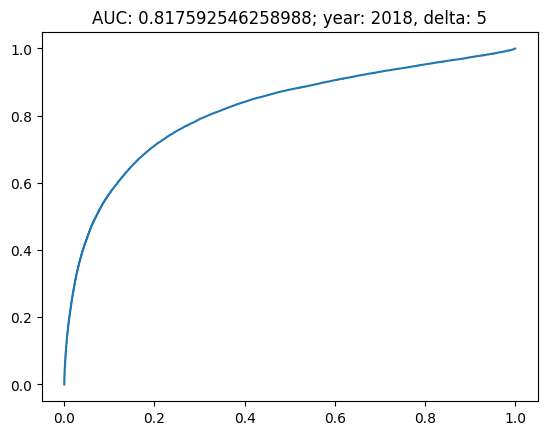

Area Under Curve for Evaluation:  0.817592546258988 





In [11]:
# Loading the validation data.
#
# full_dynamic_graph_sparse
#           The entire semantic network until 2014 (Validation,CompetitionRun=False) or 2017 (Evaluation&Submission,CompetitionRun=True).
#           numpy array, each entry describes an edge in the semantic network.
#           Each edge is described by three numbers [v1, v2, t], where the edge is formed at time t between vertices v1 and v2
#           t is measured in days since the 1.1.1990
#
# unconnected_vertex_pairs
#           numpy array of vertex pairs v1,v2 with deg(v1)>=vertex_degree_cutoff, deg(v2)>=vertex_degree_cutoff, and no edge exists in the year 2014 (2017 for CompetitionRun=True). 
#           The question that the neural network needs to solve: Will it form at least min_edges edges?
#
# unconnected_vertex_pairs_solution
#           Solution, either yes or no whether edges have been connected
#
# year_start
#           year_start=2014 (2017 for CompetitionRun=True)
#
# years_delta
#           years_delta=3
#
# vertex_degree_cutoff
#           The minimal vertex degree to be used in predictions
#
# min_edges
#           Prediction: From zero to min_edges edges between two vertices

# Testing the model, for validation.

 
all_vertex_degree_cutoff=[1] # vertex degree is 1, means that the vertex is connected to at least one other vertex
all_delta=[5] # time gap, unconnected pairs in y, the corresponding connection in y+delta
all_min_edges=[1] # every two vertices should have at least 1 edge between them


for current_delta in all_delta:
    for curr_vertex_degree_cutoff in all_vertex_degree_cutoff:
        for current_min_edges in all_min_edges:
            cur_year_start=2023-current_delta
            data_source=f"SemanticGraph_year_{str(year_start)}_delta_{str(current_delta)}_cutoff_{str(curr_vertex_degree_cutoff)}_minedge_{str(current_min_edges)}.pkl"
    
            if os.path.isfile(data_source):
                with open(data_source, "rb" ) as pkl_file:
                    full_dynamic_graph, unconnected_vertex_pairs, unconnected_vertex_pairs_solution, year_start, year_delta, vertex_degree_cutoff, min_edges = pickle.load(pkl_file)
                ## cur_year_start should be the same as year_start
                
                print(f"unconnected_vertex_pairs: {len(unconnected_vertex_pairs)}")
                print(f"unconnected_vertex_pairs_solution: {len(unconnected_vertex_pairs_solution)}")
                count_ones = np.sum(unconnected_vertex_pairs_solution == 1)
                print("Number of 1s in train_edges_solution:", count_ones)
                print(f"year_start: {year_start}; years_delta: {year_delta}; vertex_degree_cutoff: {vertex_degree_cutoff}; min_edges: {min_edges}")
                #print("Here",year_start,years_delta,year_start+years_delta)
                with open("logs_"+data_source+".txt", "a") as myfile:
                    myfile.write('Read'+str(data_source)+'\n') 

                edges_used=1e5
                percent_positive_examples=1
                batch_size=400
                lr_enc=3*10**-5
                full_rnd_seed=[42]
    
                for rnd_seed in full_rnd_seed:
                    hyper_paramters=[edges_used,percent_positive_examples,batch_size,lr_enc,rnd_seed]
    
                    all_idx=link_prediction_semnet(full_dynamic_graph,
                                                    unconnected_vertex_pairs,
                                                    year_start,#+years_delta,
                                                    year_delta,
                                                    vertex_degree_cutoff,
                                                    min_edges,
                                                    hyper_paramters,
                                                    data_source
                                                    )
                    
                    eval_info=f"year: {year_start}, delta: {year_delta}"
                    AUC=calculate_ROC(all_idx, np.array(unconnected_vertex_pairs_solution), eval_info)
                    print('Area Under Curve for Evaluation: ', AUC,'\n\n\n')
    
                    with open("logs"+data_source+".txt", "a") as log_file:
                        log_file.write("---\n")  
                        log_file.write("edges_used="+str(edges_used)+"\n") 
                        log_file.write("percent_positive_examples="+str(percent_positive_examples)+"\n") 
                        log_file.write("batch_size="+str(batch_size)+"\n") 
                        log_file.write("lr_enc="+str(lr_enc)+"\n") 
                        log_file.write("rnd_seed="+str(rnd_seed)+"\n") 
                        log_file.write("AUC="+str(AUC)+"\n\n") 
            else:
                print('File ', data_source, ' does not exist. Proceed to next parameter setting.')

## check different period?

In [ ]:
if not ('saved_files/full_dynamic_graph_sparse' in locals() or 'saved_files/full_dynamic_graph_sparse' in globals()):
    print('Read full graph')
    with open('saved_files/graph_edges.pkl', "rb" ) as pkl_file:
        full_dynamic_graph_sparse_read = pickle.load(pkl_file)
        
    full_dynamic_graph_sparse=[]
    cc=0
    for edge in full_dynamic_graph_sparse_read:
        if edge[0]!=edge[1]:
            full_dynamic_graph_sparse.append(edge)
        else:
            print(cc,': ',edge) 
            
    full_dynamic_graph_sparse_read=[]        

else:
    print('already stored all_edges')

print('done')

## prepare unconnected pairs for a different checking period 

current_delta=3
curr_vertex_degree_cutoff=1
current_min_edges=1    
year_start=2023-current_delta 

dynamic_graph_sparse, edges_for_checking, edges_for_solution = create_training_data(
    full_graph=np.array(full_dynamic_graph_sparse),
    year_start=year_start,
    years_delta=current_delta,
    min_edges=current_min_edges,
    edges_used=1e7,
    vertex_degree_cutoff=curr_vertex_degree_cutoff
)

## calculate futures: 
day_origin = date(1990,1,1)
eval_sparse=[]
years=[year_start,year_start-1,year_start-2]
for yy in years:
    print('    Create Graph for ', yy)
    day_curr=date(yy,12,31)
    eval_edges_curr=dynamic_graph_sparse[dynamic_graph_sparse[:,2]<(day_curr-day_origin).days]
    adj_mat_sparse_curr = sparse.csr_matrix(
                                            (np.ones(len(eval_edges_curr)), (eval_edges_curr[:,0], eval_edges_curr[:,1])),
                                            shape=(NUM_OF_VERTICES,NUM_OF_VERTICES)
                                        )

    eval_sparse.append(adj_mat_sparse_curr)

print('    compute all properties for evaluation')
eval_examples=compute_all_properties_of_list(eval_sparse,edges_for_checking,data_source)
eval_examples=np.array(eval_examples)

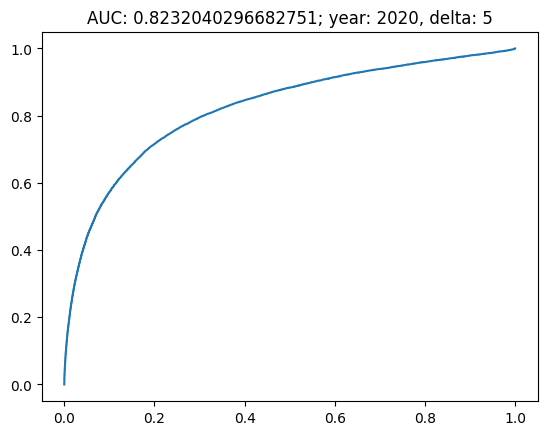

test/evaluate with different time frame, AUC: {AUC}


In [14]:
 
## load NN 
trained_delta=5 # depend on your train period
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_semnet = ff_network().to(device)
model_semnet = torch.load(f"neural_net_full_{2013}_{5}")
model_semnet.eval() 
eval_examples=torch.tensor(eval_examples, dtype=torch.float).to(device)   
all_predictions_eval=flatten(model_semnet(eval_examples).detach().cpu().numpy())
sorted_predictions_eval=np.flip(np.argsort(all_predictions_eval,axis=0))  
eval_info=f"year: {year_start}, delta: {year_delta}"
AUC=calculate_ROC(sorted_predictions_eval, np.array(edges_for_solution), eval_info)
print(f"test/evaluate with different time frame, AUC: {AUC}")